# Artificial Neural Networks and Deep Learning

---

## Homework 1: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.
2. Upload the `training_set.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.zip` file to Codabench.


## 🌐 Connect Colab to Google Drive

In [ ]:
import os
from google.colab import drive

# Mount Google Drive at /gdrive
drive.mount('/gdrive')

# Change the current working directory to the specified path
os.chdir('/gdrive/My Drive/[2024-2025] AN2DL/Homework 1')
print(os.getcwd())

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1sSibCfy_Un23b5TdxDLKTE7IU5sAPeKD/[2024-2025] AN2DL/Homework 1


## ⚙️ Import Libraries

In [ ]:
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import mixed_precision
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.utils import shuffle

import datetime
import cv2


import random

import seaborn as sns
import matplotlib.pyplot as plt

seed = 69
np.random.seed(seed)
tf.random.set_seed(seed)

mixed_precision.set_global_policy('mixed_float16')


## ⏳ Load the Data

In [ ]:
data = np.load('training_set.npz')
X = data['images']
Y = data['labels']

# Data Cleaning



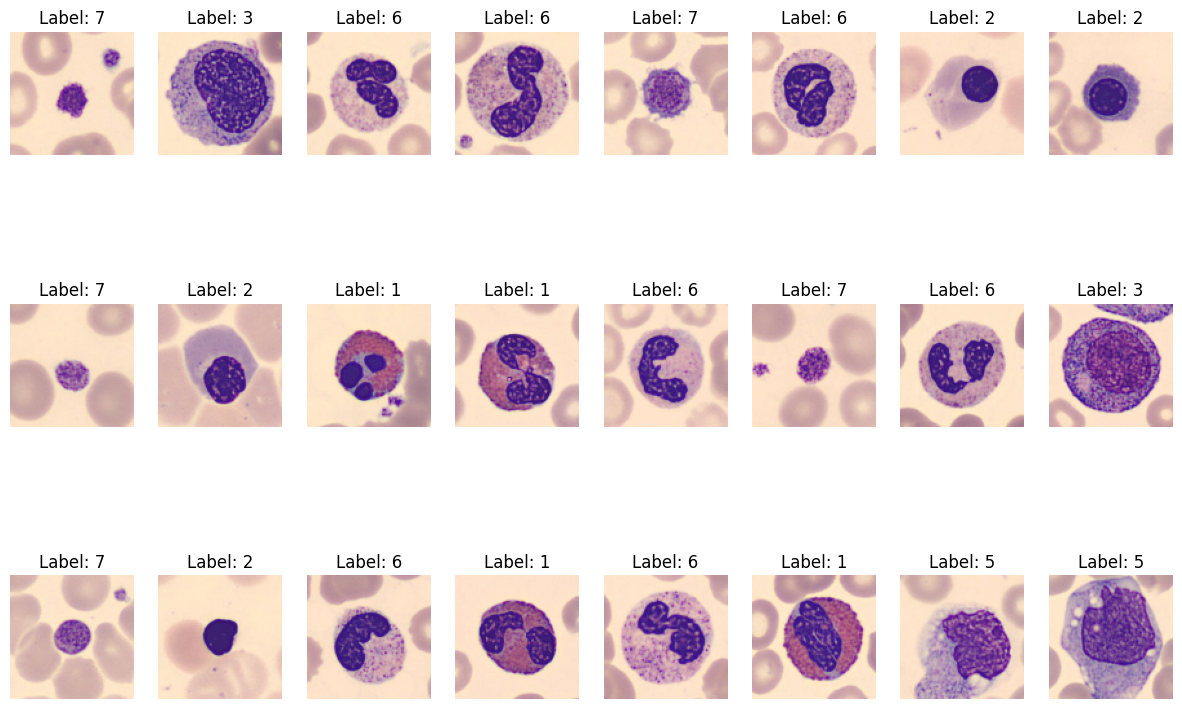

[[   0 1052]
 [   1 2381]
 [   2 1285]
 [   3 2226]
 [   4 1049]
 [   5 1393]
 [   6 2530]
 [   7 1843]]
Shape before removing meme images: (13759, 96, 96, 3)


In [ ]:
# Function to plot sample images from the dataset
def plot_sample_images(X, Y, num_samples=8, col = 3):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples*col):
        plt.subplot(col, num_samples, i + 1)
        plt.imshow(X[i])
        plt.title(f'Label: {Y[i]}')
        plt.axis('off')
    plt.show()

# Plot sample images from the training set
plot_sample_images(X, Y.flatten())

# Check if the dataset is balanced
unique, counts = np.unique(Y, return_counts=True)
print(np.asarray((unique, counts)).T)

del unique, counts

# Remove meme images
print(f"Shape before removing meme images: {X.shape}")
meme_indices = range(11959, X.shape[0])
X = np.delete(X, meme_indices, axis=0)
Y = np.delete(Y, meme_indices, axis=0)


# Creation of the Test Set - before Data Augmentation

I DON'T normalize the images, but keep them in the range [0, 255]. this since some augmentation techniques seem to work better in [0, 255]

In [ ]:

X_train, val_X, y_train, val_Y = train_test_split(X, Y,
                                                  random_state=seed, test_size=0.30,
                                                    stratify=np.argmax(Y,axis=1))
"""
X_train, val_X, y_train, val_Y = train_test_split(X, Y, random_state=seed, test_size=0.30, stratify=np.argmax(Y, axis=1))
X_test, val_X, y_test, val_Y = train_test_split(val_X, val_Y, random_state=seed, test_size=0.40, stratify=np.argmax(val_Y, axis=1))
X_test = X_test/255
"""
# The first part coincides with the report result. Run the second one only if you want to test


In [ ]:
del data, X, Y

# Preprocessing

#### Random Augmentation

In [ ]:
def plot_sample_images(X, Y, num_samples=8, row = 5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples*row):
        plt.subplot(row, num_samples, i + 1)
        plt.imshow(X[-i])
        plt.title(f'Label: {Y[-i]}')
        plt.axis('off')
    plt.show()

def augment_img(img, augmentation):
    """
    Augment a single image using the specified augmentation pipeline.
    """
    augmented_img = tf.clip_by_value(augmentation(img), 0., 1.)
    return augmented_img.numpy().astype(np.float32)

def augment_data(data, labels, augmentation,  number_img = 1000):
    """
    Augment a dataset using the specified augmentation pipeline and return the augmented data concatenated with the original data.
    """
    image_to_generate = max(number_img - len(data), 0)
    data_augmented = np.zeros((image_to_generate, *data.shape[1:]), dtype=data.dtype)
    labels_augmented = np.zeros((image_to_generate, *labels.shape[1:]), dtype=labels.dtype)

    for i in range(image_to_generate):
        index = np.random.randint(0, len(data))
        data_augmented[i] = augment_img(data[index], augmentation)
        labels_augmented[i] = labels[index]

    return np.concatenate((data, data_augmented), axis=0), np.concatenate((labels, labels_augmented), axis=0)

def class_balancing(data, labels, augmentation, number_img_per_class = 10, verbose = 0):
    """
    Function to balance class distribution in the training data with augmentation
    """
    unique_classes, counts = np.unique(labels, return_counts=True)
    print(f"Number of classes: {len(unique_classes)}")
    print(f"Number of images per class: {counts}")
    number_aug = np.maximum(number_img_per_class - counts, 0)
    print(f"Number of augmented images per class: {number_aug}\n")

    data_balanced = np.zeros((number_img_per_class * len(unique_classes), *data.shape[1:]), dtype=data.dtype)
    labels_balanced = np.zeros((number_img_per_class * len(unique_classes), *labels.shape[1:]), dtype=labels.dtype)

    for i, c in enumerate(unique_classes):
        print(f"Augmenting class {c}")
        class_indices = np.where(labels == c)[0]
        class_data = data[class_indices]
        class_labels = labels[class_indices]
        augmented_data, augmented_labels = augment_data(class_data, class_labels, augmentation, number_img_per_class)

        if verbose:
            plot_sample_images(augmented_data, augmented_labels)

        start = i * number_img_per_class
        end = (i + 1) * number_img_per_class
        data_balanced[start:end] = augmented_data
        labels_balanced[start:end] = augmented_labels

    return data_balanced, labels_balanced


def display_class_distribution(xxxx, title="Class Distribution"):
    """
    Display the distribution of classes in a dataset
    """
    print(f"{title}:")
    unique, counts = np.unique(xxxx, return_counts=True)
    print(np.asarray((unique, counts)).T)



Number of classes: 8
Number of images per class: [ 585 1537  765 1409  583  705 1638 1149]
Number of augmented images per class: [1415  463 1235  591 1417 1295  362  851]

Augmenting class 0


Augmenting class 1


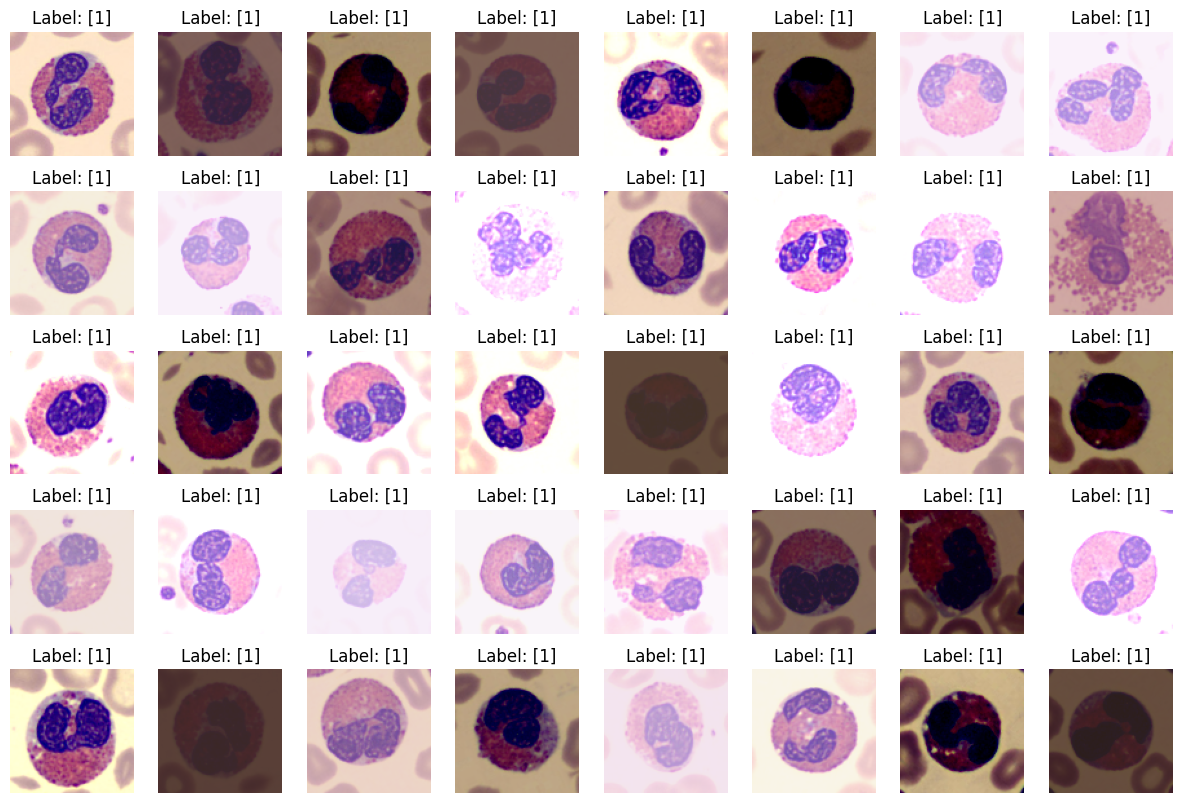

Augmenting class 2


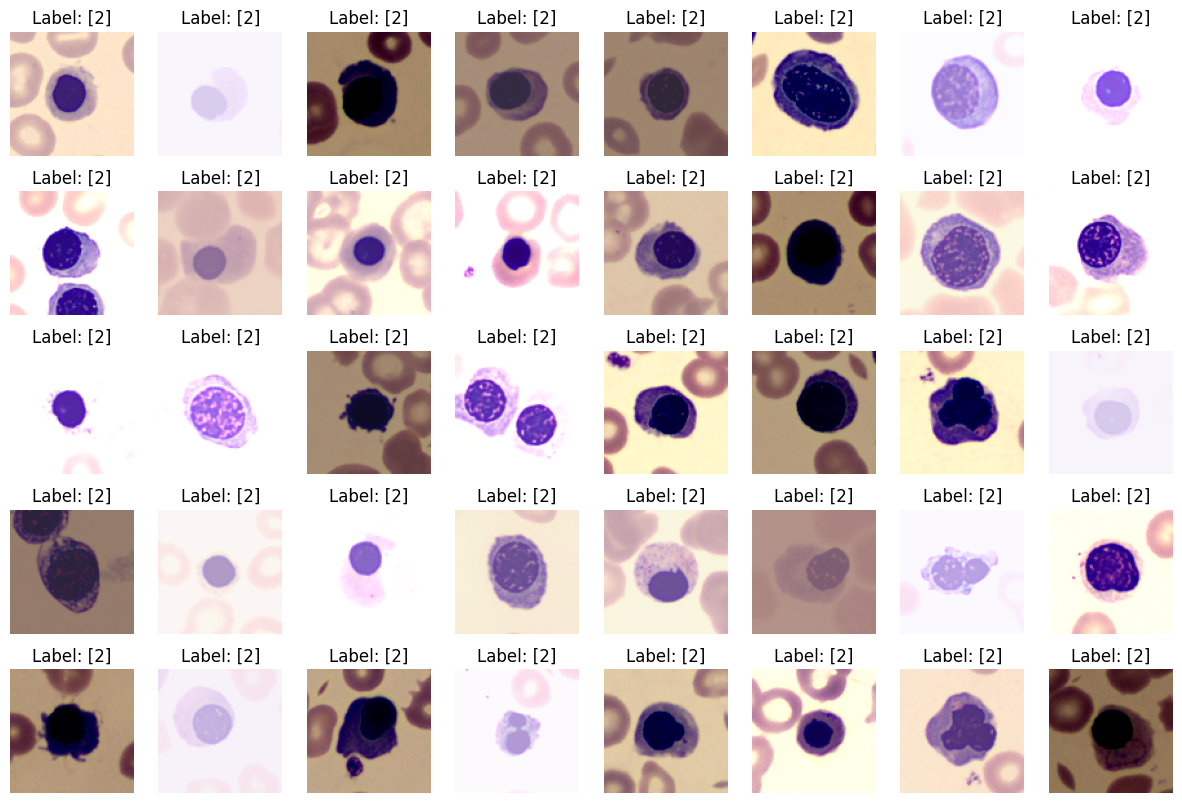

Augmenting class 3


Augmenting class 4


Augmenting class 5


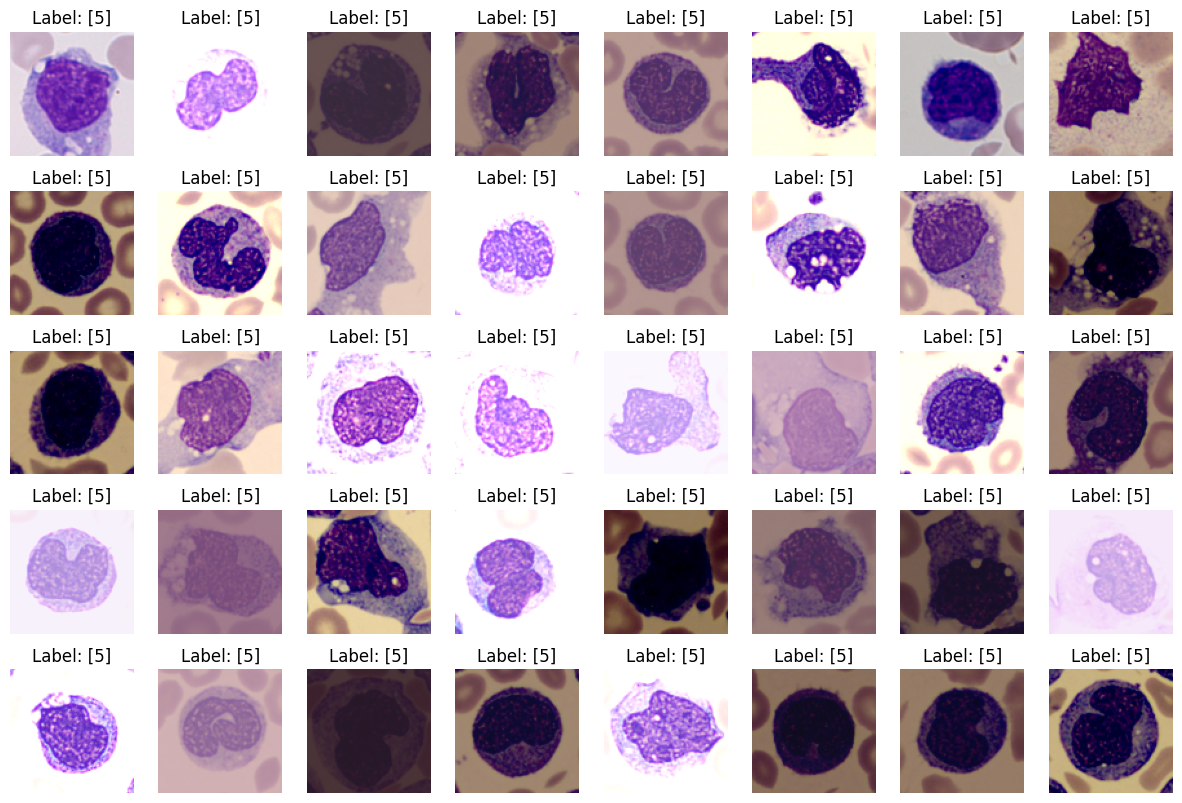

Augmenting class 6


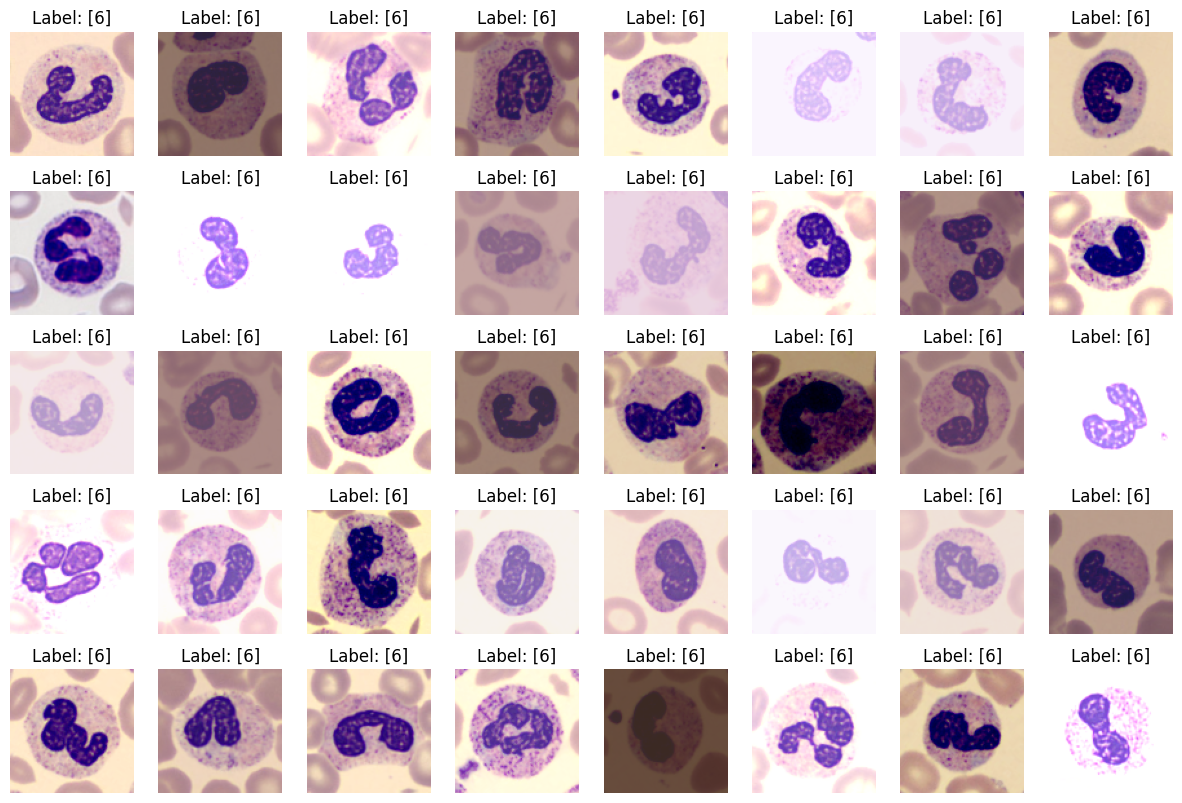

Augmenting class 7


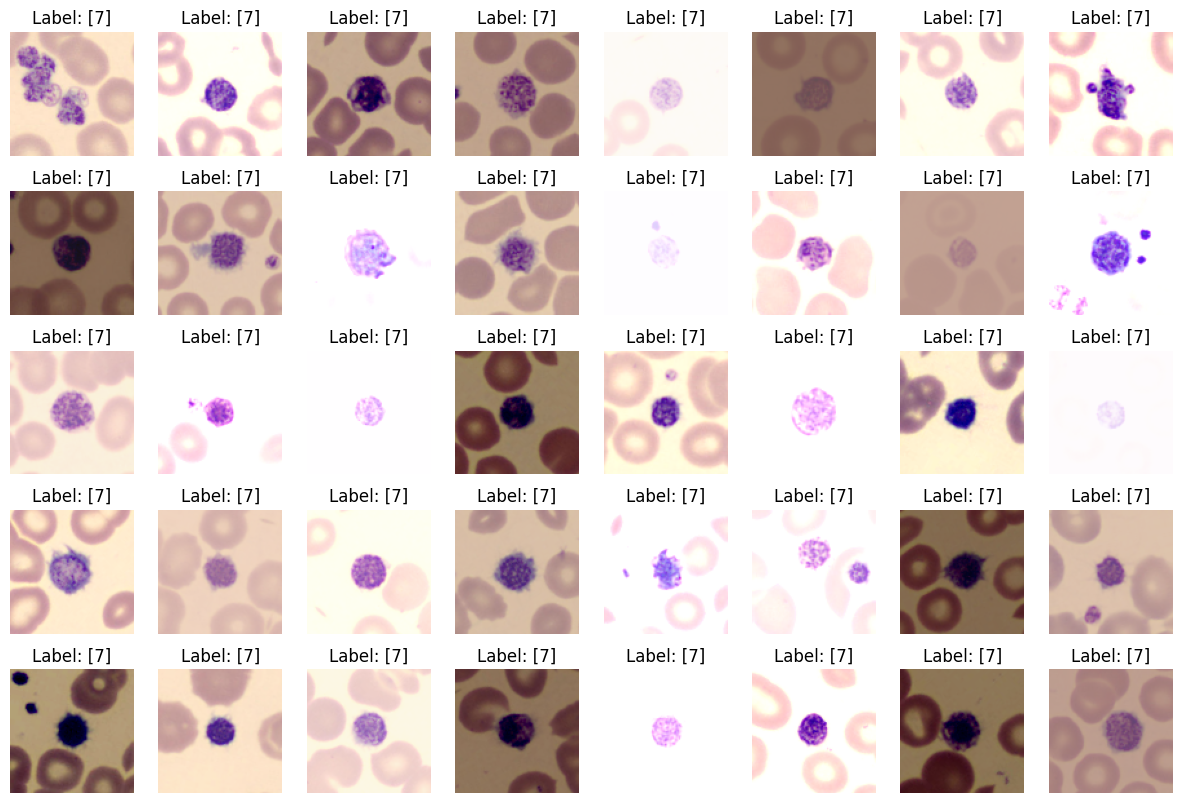

Augmented Class Distribution:
[[   0 2000]
 [   1 2000]
 [   2 2000]
 [   3 2000]
 [   4 2000]
 [   5 2000]
 [   6 2000]
 [   7 2000]]


In [ ]:
augmentation = tfk.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomRotation(1), # 1 set it all 360°, value range is of the pixels
    tfkl.RandomBrightness(0.5, value_range=(0,1)),
    tfkl.RandomContrast(0.8),
], name='Augmentation')


# Normalize the input
X_train = X_train/255
X_augmented, y_augmented = class_balancing(X_train, y_train, augmentation, 2000, verbose = 1)

display_class_distribution(y_augmented, "Augmented Class Distribution")

In [ ]:

print(f"Data post augmentation shape: {X_augmented.shape}")
print(f"Labels post augmentation shape: {y_augmented.shape}")

X_train = X_augmented
y_train = y_augmented
del X_augmented, y_augmented


# One-hot encode the labels of the training
y_train = tfk.utils.to_categorical(y_train)
val_Y = tfk.utils.to_categorical(val_Y)

print(y_train.shape)
print(val_Y.shape)


Data post augmentation shape: (16000, 96, 96, 3)
Labels post augmentation shape: (16000, 1)
(16000, 8)
(3588, 8)


# Transfer learning using Exception


In [ ]:
# Set output classes
output_shape = 8

input_shape = (96, 96, 3)

# Define the input layer with your custom input size
inputs = tfkl.Input(shape=input_shape, name='input_layer')

# Use tfkl.Resizing to resize input to 299x299
x = tfkl.Resizing(height=299, width=299, interpolation="bilinear")(inputs)

# Load the Xception model without the top layers (for feature extraction)
xception_base = tfk.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(299, 299, 3)
)

# Freeze the Xception base model to use it as a feature extractor
xception_base.trainable = False

# Pass the upsampled inputs through the Xception base
x = xception_base(x)

# Add dropout for regularization
x = tfkl.Dropout(0.3, name='dropout')(x)

# Add a global average pooling layer to reduce spatial dimensions
x = tfkl.GlobalAveragePooling2D(name='gap')(x)

# Add a dense layer for final output
x = tfkl.Dense(output_shape, name='dense')(x)

# Apply softmax activation for classification
outputs = tfkl.Activation('softmax', name='softmax')(x)

# Define the model
model = tfk.Model(inputs=inputs, outputs=outputs, name='xception_transfer_learning')

# Compile the model
model.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Adam(),
    metrics=['accuracy']
)

# Summary of the model
model.summary(expand_nested=True)

# Set the number of GPUs to use
#num_gpus = 2

# Create the multi-GPU model
#strategy = tf.distribute.MirroredStrategy(devices=[f"/gpu:{i}" for i in range(num_gpus)])

#with strategy.scope():
#    model = create_model(input_shape, output_shape, pretrained_net, augmentation_layer=augmentation)

Model: "xception_transfer_learning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast (Cast)                          │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_conv1 (Conv2D)           │ (None, 149, 149, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_conv1_bn                 │ (None, 149, 149, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_conv1_act (Activation)   │ (None, 149, 149, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_conv2 (Conv2D)           │ (None, 147, 147, 64)        │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_conv2_bn                 │ (None, 147, 147, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_conv2_act (Activation)   │ (None, 147, 147, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_sepconv1                 │ (None, 147, 147, 128)       │           8,768 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_sepconv1_bn              │ (None, 147, 147, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_sepconv2_act             │ (None, 147, 147, 128)       │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_sepconv2                 │ (None, 147, 147, 128)       │          17,536 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_sepconv2_bn              │ (None, 147, 147, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2d (Conv2D)                 │ (None, 74, 74, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_pool (MaxPooling2D)      │ (None, 74, 74, 128)         │              

 Total params: 20,877,872 (79.64 MB)

 Trainable params: 16,392 (64.03 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
val_X = val_X/255

In [ ]:
# Transfer learning: Train with frozen Xception base model
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=50,
    validation_data=(val_X, val_Y),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
)

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 63s 87ms/step - accuracy: 0.6380 - loss: 1.1885 - val_accuracy: 0.8562 - val_loss: 0.5297
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - accuracy: 0.8392 - loss: 0.5304 - val_accuracy: 0.8871 - val_loss: 0.4177
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - accuracy: 0.8663 - loss: 0.4245 - val_accuracy: 0.8991 - val_loss: 0.3665
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 69ms/step - accuracy: 0.8844 - loss: 0.3684 - val_accuracy: 0.9044 - val_loss: 0.3375
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 69ms/step - accuracy: 0.8952 - loss: 0.3308 - val_accuracy: 0.9097 - val_loss: 0.3161
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 77ms/step - accuracy: 0.9047 - loss: 0.3044 - val_accuracy: 0.9122 - val_loss: 0.3002
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - accuracy: 0.9103 - loss: 0.2826 - val_accuracy: 0.9147 - val_loss: 0.2873
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 69ms/step - accuracy: 0.9180 - loss: 0.2648 - 

In [ ]:
# Fine-tuning: Unfreeze some layers in Xception for further training
xception_base.trainable = True

# Optionally, you can freeze the first few layers of Xception (fine-tuning only upper layers)
for layer in xception_base.layers[:80]:  # Example: Freeze first 80 layers out of ~125 total in Xception
    layer.trainable = False

# Compile with a lower learning rate for fine-tuning
fine_tune_lr = 1e-4
model.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Adam(learning_rate=fine_tune_lr),
    metrics=['accuracy']
)

# Fine-tuning with early stopping
fine_tune_history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=30,
    validation_data=(val_X, val_Y),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=6, restore_best_weights=True)]
)

# Save the fine-tuned model
model.save('fine_tuned_xception_model.keras')
model.save('weights.keras')

final_val_accuracy = round(max(fine_tune_history.history['val_accuracy']) * 100, 2)
#del model

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 98s 131ms/step - accuracy: 0.8627 - loss: 0.5773 - val_accuracy: 0.9660 - val_loss: 0.1103
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 114s 117ms/step - accuracy: 0.9883 - loss: 0.0383 - val_accuracy: 0.9693 - val_loss: 0.1372
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 86s 126ms/step - accuracy: 0.9968 - loss: 0.0109 - val_accuracy: 0.9735 - val_loss: 0.1149
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 59s 117ms/step - accuracy: 0.9946 - loss: 0.0190 - val_accuracy: 0.9621 - val_loss: 0.1824
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 117ms/step - accuracy: 0.9936 - loss: 0.0169 - val_accuracy: 0.9710 - val_loss: 0.1675
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 58s 116ms/step - accuracy: 0.9950 - loss: 0.0150 - val_accuracy: 0.9613 - val_loss: 0.2372
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 58s 116ms/step - accuracy: 0.9939 - loss: 0.0182 - val_accuracy: 0.9674 - val_loss: 0.1609
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 116ms/step - accuracy: 0.9951 - loss: 

## 🛠️ Train and Save the Model

In [ ]:
# Remove old weights file if it exists
if os.path.exists('weights.keras'):
    os.remove('weights.keras')

model.save('weights.keras')
del model

NameError: name 'model' is not defined

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        X = X/255
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [ ]:
"""
from model import Model

temp = Model()

test_test = test_X
test_predictions = temp.predict(test_test)
print(f"Results: {test_predictions}")
print(f"Expected: {test_gt}")

# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

val_test = val_X
val_predictions = temp.predict(val_test)
print(f"Results: {val_predictions}")
print(f"Expected: {np.argmax(val_Y, axis = -1)}")
test_accuracy = accuracy_score(np.argmax(val_Y, axis = -1), val_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')
"""
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

fine_tune_model = tfk.models.load_model('BEST_MODEL/weights.keras')

print(f"Preprocessing validation set for Xception")
if np.max(X_test) > 1:
    X_test = X_test / 255
else:
    X_test = X_test

# Test the model and print the test accuracy
test_predictions = fine_tune_model.predict(X_test, verbose=1)
test_predictions = np.argmax(test_predictions, axis=-1)

# Extract ground truth classes
test_gt = y_test.flatten()
print(f"test_prediction: {test_predictions}")
print(f"test_gt: {test_gt}")

# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(test_gt, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate recall
test_recall = recall_score(test_gt, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate F1 score
test_f1 = f1_score(test_gt, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

try:
    test_roc_auc = roc_auc_score(y_test, fine_tune_model.predict(X_test), multi_class='ovr', average='weighted')
    print(f'ROC AUC score over the test set: {round(test_roc_auc, 4)}')
except ValueError as e:
    print(f"ROC AUC score could not be calculated: {e}")


# Calculate and plot the confusion matrix
cm = confusion_matrix(test_gt, test_predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Preprocessing validation set for Xception
68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step
test_prediction: [2 0 6 ... 6 3 3]
test_gt: [2 0 6 ... 6 3 3]
Accuracy score over the test set: 0.9791
Precision score over the test set: 0.9792
Recall score over the test set: 0.9791
F1 score over the test set: 0.9791
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step
ROC AUC score could not be calculated: Target scores need to be probabilities for multiclass roc_auc, i.e. they should sum up to 1.0 over classes


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)